In [1]:
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import os
from copy import deepcopy
from utils.tddfa_util import str2bool
from fdc_utils import *
import argparse

parser = argparse.ArgumentParser(description='The demo of still image of 3DDFA_V2')
parser.add_argument('-c', '--config', type=str, default='configs/mb1_120x120.yml')
parser.add_argument('-f', '--img_fp', type=str, default='examples/inputs/trump_hillary.jpg')
parser.add_argument('-m', '--mode', type=str, default='cpu', help='gpu or cpu mode')
parser.add_argument('-o', '--opt', type=str, default='2d_sparse', choices=['2d_sparse', '2d_dense', '3d', 'depth', 'pncc', 'uv_tex', 'pose', 'ply', 'obj'])
# parser.add_argument('--show_flag', type=str2bool, default='true', help='whether to show the visualization result')
parser.add_argument('--onnx', action='store_true', default=False)

args = parser.parse_args()

video_parent_path = '/nfs/STG/Audio2FacePose/MEAD/New_frames_1'
video_name = 'video_001'
exp = 'angry'
level = 'level_1'
clip = '001'
image_name = '000.jpg'
front_image_path = os.path.join(video_parent_path, video_name, 'front', exp, level, clip, image_name)
top_image_path = os.path.join(video_parent_path, video_name, 'top', exp, level, clip, image_name)

front_image = cv2.imread(front_image_path)
top_image = cv2.imread(top_image_path)

front_raw_landmarks = detect_attributes(front_image, args)
top_raw_landmarks = detect_attributes(top_image, args)

new_front_image = detect_face(front_image, front_raw_landmarks)
new_top_image = detect_face(top_image, top_raw_landmarks)

front_landmarks = detect_attributes(new_front_image, args)
top_landmarks = detect_attributes(new_top_image, args)

is_partial = True

if is_partial:
    front_u = front_landmarks[0, :][17:]
    front_v = front_landmarks[1, :][17:]
    front_z = front_landmarks[2, :][17:]

    top_u = top_landmarks[0, :][17:]
    top_v = top_landmarks[1, :][17:]
    top_z = top_landmarks[2, :][17:]
else:
    front_u = front_landmarks[0, :]
    front_v = front_landmarks[1, :]
    front_z = front_landmarks[2, :]

    top_u = top_landmarks[0, :]
    top_v = top_landmarks[1, :]
    top_z = top_landmarks[2, :]

/home/uss00067/anaconda3/envs/facial/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


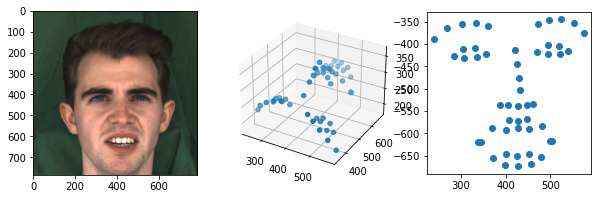

In [2]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(131)
vis_new_front_image = cv2.cvtColor(new_front_image, cv2.COLOR_BGR2RGB)
ax.imshow(vis_new_front_image)
ax = fig.add_subplot(132, projection='3d')
ax.scatter(front_u,front_v,front_z)
ax = fig.add_subplot(133)
ax.scatter(front_u,-front_v)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

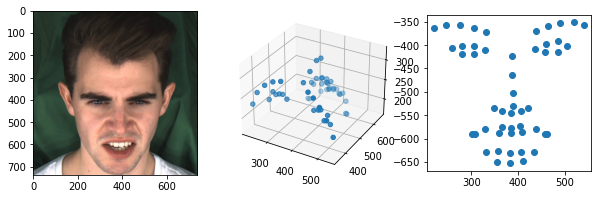

In [3]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(131)
vis_new_top_image = cv2.cvtColor(new_top_image, cv2.COLOR_BGR2RGB)
ax.imshow(vis_new_top_image)
ax = fig.add_subplot(132, projection='3d')
ax.scatter(top_u,top_v,top_z)
ax = fig.add_subplot(133)
ax.scatter(top_u,-top_v)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

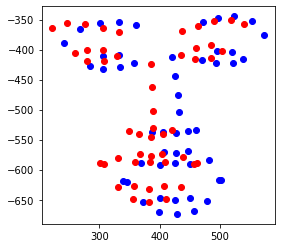

In [4]:
plt.scatter(front_u, -front_v, c='b')
plt.scatter(top_u, -top_v, c='r')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

[[ 1.11133777e+00  1.25793770e-01 -3.65672664e+01]
 [-3.25796930e-02  1.28432947e+00 -6.65382060e+01]
 [-2.77872523e-05  1.82387812e-04  1.00000000e+00]]


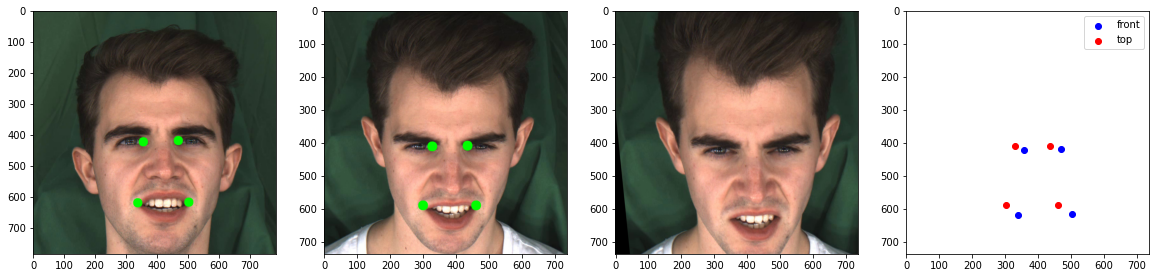

In [5]:
from copy import deepcopy

vis_new_front_image = deepcopy(new_front_image)
vis_new_top_image = deepcopy(new_top_image)
vis_new_front_image = cv2.cvtColor(vis_new_front_image, cv2.COLOR_BGR2RGB)
vis_new_top_image = cv2.cvtColor(vis_new_top_image, cv2.COLOR_BGR2RGB)

# Index starts from 0!!
if is_partial:
    frist_idx = 39-17
    second_idx = 42-17
    third_idx = 48-17
    last_idx = 54-17
else:
    frist_idx = 17
    second_idx = 26
    third_idx = 48
    last_idx = 54

front_pts = np.float32(
[[front_u[frist_idx], front_v[frist_idx]],
 [front_u[second_idx], front_v[second_idx]],
 [front_u[third_idx], front_v[third_idx]],
 [front_u[last_idx], front_v[last_idx]]]
)

top_pts = np.float32(
[[top_u[frist_idx], top_v[frist_idx]],
 [top_u[second_idx], top_v[second_idx]],
 [top_u[third_idx], top_v[third_idx]],
 [top_u[last_idx], top_v[last_idx]]]
)

front_pts_array = np.array(front_pts)
top_pts_array = np.array(top_pts)

for front_pt in front_pts:
    cv2.circle(vis_new_front_image,(int(front_pt[0]),int(front_pt[1])),15,(0,255,0),-1)

for top_pt in top_pts:
    cv2.circle(vis_new_top_image,(int(top_pt[0]),int(top_pt[1])),15,(0,255,0),-1)

transformation_matrix = cv2.getPerspectiveTransform(top_pts, front_pts)
print(transformation_matrix)

warped_front = cv2.warpPerspective(new_top_image, transformation_matrix, (new_top_image.shape[0], new_top_image.shape[1]), flags=cv2.INTER_LINEAR)
vis_warped_front = cv2.cvtColor(warped_front, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(141)
ax1.imshow(vis_new_front_image)
ax1.set_aspect('equal', 'box')

ax2 = fig.add_subplot(142)
ax2.imshow(vis_new_top_image)
ax2.set_aspect('equal', 'box')

ax3 = fig.add_subplot(143)
ax3.imshow(vis_warped_front)
ax3.set_aspect('equal', 'box')

ax4 = fig.add_subplot(144)
ax4.scatter(front_pts_array[:, 0], front_pts_array[:, 1], c='b', label='front')
ax4.scatter(top_pts_array[:, 0], top_pts_array[:, 1], c='r', label='top')
ax4.legend(loc="upper right")
ax4.set_aspect('equal', 'box')
ax4.set_xlim([0, new_top_image.shape[0]])
ax4.set_ylim([0, new_top_image.shape[0]])
plt.gca().invert_yaxis()

plt.show()

In [6]:
ones_vec = np.ones((top_pts_array.shape[0]))[:, np.newaxis]
new_top_pts_array = np.hstack((top_pts_array, ones_vec)).transpose()
temp_transformation_matrix = transformation_matrix
warped_top_pts_array = np.matmul(temp_transformation_matrix, new_top_pts_array)
normalized_warped_top_pts_array = warped_top_pts_array / warped_top_pts_array[2, :]
vis_warped_top_pts_array = normalized_warped_top_pts_array.transpose()[:, :2]
print(vis_warped_top_pts_array)

[[356.74261433 422.63385091]
 [469.98242112 418.12640491]
 [338.4354244  619.5291727 ]
 [503.07391628 617.27136184]]


In [7]:
long_ones_vec = np.ones((front_u.shape[0]))[:, np.newaxis]
new_top_ldms = np.hstack((top_u[:, np.newaxis], top_v[:, np.newaxis], long_ones_vec)).transpose()
warped_top_ldms = np.matmul(temp_transformation_matrix, new_top_ldms)
normalized_warped_top_ldms = warped_top_ldms / warped_top_ldms[2, :]
vis_front_ldms = np.hstack((front_u[:, np.newaxis], front_v[:, np.newaxis]))
vis_top_ldms = np.hstack((top_u[:, np.newaxis], top_v[:, np.newaxis]))
vis_top_pred_ldms = normalized_warped_top_ldms.transpose()[:, :2]
print(vis_top_pred_ldms.shape)

(51, 2)


In [8]:
def vis_two_pts(src_pts, pred_pts, gt_pts):
    # Inputs shape: [n, 2]
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(121)
    ax1.scatter(gt_pts[:, 0], gt_pts[:, 1], c='b', label='front')
    ax1.scatter(src_pts[:, 0], src_pts[:, 1], c='r', label='top')
    ax1.legend(loc="upper right")
    ax1.set_aspect('equal', 'box')
    ax1.set_xlim([0, new_top_image.shape[0]])
    ax1.set_ylim([0, new_top_image.shape[0]])
    dist_1 = np.mean(np.sqrt((src_pts[:, 0] - gt_pts[:, 0])**2 + (src_pts[:, 1] - gt_pts[:, 1])**2))
    plt.gca().invert_yaxis()

    ax2 = fig.add_subplot(122)
    ax2.scatter(gt_pts[:, 0], gt_pts[:, 1], c='b', label='front')
    ax2.scatter(pred_pts[:, 0], pred_pts[:, 1], c='r', label='top')
    ax2.legend(loc="upper right")
    ax2.set_aspect('equal', 'box')
    ax2.set_xlim([0, new_top_image.shape[0]])
    ax2.set_ylim([0, new_top_image.shape[0]])
    dist_2 = np.mean(np.sqrt((pred_pts[:, 0] - gt_pts[:, 0])**2 + (pred_pts[:, 1] - gt_pts[:, 1])**2))
    plt.gca().invert_yaxis()
    
    plt.show()
    print('Original distance: ', dist_1)
    print('New distance: ', dist_2)

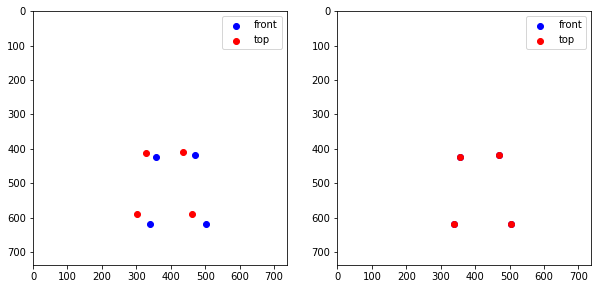

Original distance:  40.89733
New distance:  1.7829920521162145e-06


In [9]:
vis_two_pts(top_pts_array, vis_warped_top_pts_array, front_pts_array)

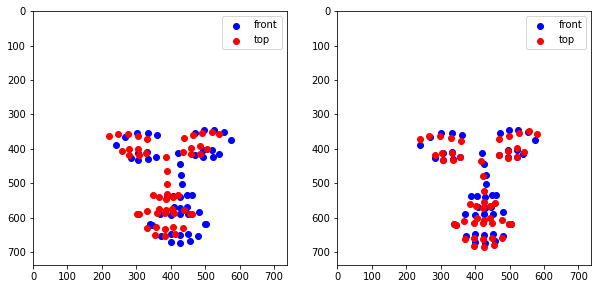

Original distance:  39.68015
New distance:  15.167259707401113


In [10]:
vis_two_pts(vis_top_ldms, vis_top_pred_ldms, vis_front_ldms)

In [11]:
homography_matrix, mask = cv2.findHomography(vis_top_ldms, vis_front_ldms, cv2.RANSAC,5.0)
print('homography matrix: ', homography_matrix)
transformation_matrix_1 = homography_matrix
warped_top_pts_array_1 = np.matmul(transformation_matrix_1, new_top_pts_array)
normalized_warped_top_pts_array_1 = warped_top_pts_array_1 / warped_top_pts_array_1[2, :]
vis_warped_top_pts_array_1 = normalized_warped_top_pts_array_1.transpose()[:, :2]

warped_top_ldms_1 = np.matmul(transformation_matrix_1, new_top_ldms)
normalized_warped_top_ldms_1 = warped_top_ldms_1 / warped_top_ldms_1[2, :]
vis_top_pred_ldms_1 = normalized_warped_top_ldms_1.transpose()[:, :2]

homography matrix:  [[ 1.08368448e+00  9.54660139e-02 -2.49375336e+01]
 [-1.72378877e-02  1.14576991e+00 -2.84202927e+01]
 [ 1.28148217e-07  8.80557453e-05  1.00000000e+00]]


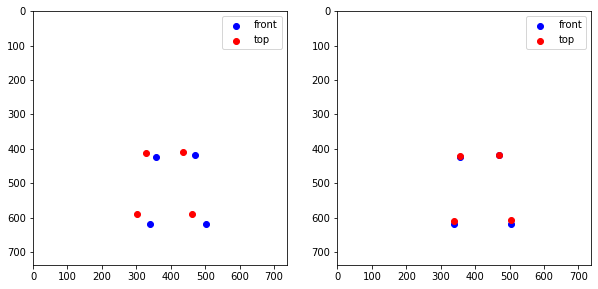

Original distance:  40.89733
New distance:  5.368495799617969


In [12]:
vis_two_pts(top_pts_array, vis_warped_top_pts_array_1, front_pts_array)

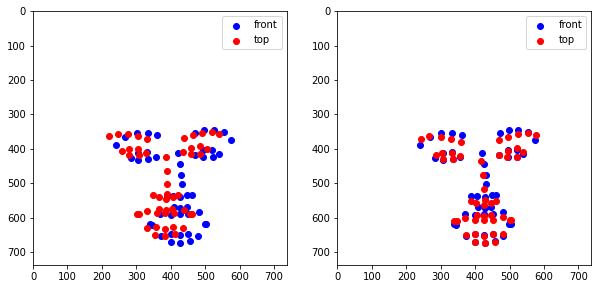

Original distance:  39.68015
New distance:  11.903589081151878


In [13]:
vis_two_pts(vis_top_ldms, vis_top_pred_ldms_1, vis_front_ldms)

In [14]:
print(vis_front_ldms.transpose().shape)
print(new_top_ldms.shape)

(2, 51)
(3, 51)


In [15]:
print(new_top_image.shape)

(737, 737, 3)


In [16]:
new_top_image_u_center = new_top_image.shape[0]/2.
new_top_image_v_center = new_top_image.shape[1]/2.
print(new_top_image_u_center)
print(new_top_image_v_center)

368.5
368.5


In [17]:
from copy import deepcopy

new_top_ldms_r = np.zeros((new_top_ldms.shape[0]+1, new_top_ldms.shape[1]))

for i in range(new_top_ldms.shape[1]):
    temp_u = new_top_ldms[:, i][0]
    temp_v = new_top_ldms[:, i][1]
    temp_r = np.sqrt((temp_u-new_top_image_u_center)**2+(temp_v-new_top_image_v_center)**2)
    temp_vec = np.append(new_top_ldms[:, i], temp_r)
    new_top_ldms_r[:, i] = temp_vec

In [23]:
# Reference: https://towardsdatascience.com/camera-calibration-with-example-in-python-5147e945cdeb

from scipy.optimize import minimize

distortion_mode = 'tangential' # 'none'; 'radial'; 'tangential'; 'combined'

def geometric_error(m, gt_pts, pred_pts):
    assert gt_pts.shape[1] == pred_pts.shape[1] # Check the number of the pts
    error = 0
    n_points = gt_pts.shape[1]
    for i in range(n_points):
        X, Y, Z, r = pred_pts[:, i]
        u, v = gt_pts[:, i]
        u_ = m[0] * X + m[1] * Y + m[2] * Z
        v_ = m[3] * X + m[4] * Y + m[5] * Z
        d = m[6] * X + m[7] * Y +  1 * Z 
        original_u_ = u_/d
        original_v_ = v_/d
        
        if distortion_mode == 'radial':
            u_ = original_u_ * (1 + m[8] * r**2 + m[9] * r**4)
            v_ = original_v_ * (1 + m[8] * r**2 + m[9] * r**4)
        elif distortion_mode == 'tangential':
            u_ = 2 * m[10] * original_u_ * original_v_ + m[11] * (r**2 + 2 * original_u_**2)
            v_ = m[10] * (r**2 + 2 * original_v_**2) + 2 * m[11] * original_u_ * original_v_
        elif distortion_mode == 'combined':
            u_ = original_u_ * (1 + m[8] * r**2 + m[9] * r**4) + 2 * m[10] * original_u_ * original_v_ + m[11] * (r**2 + 2 * original_u_**2)
            v_ = original_v_ * (1 + m[8] * r**2 + m[9] * r**4) + m[10] * (r**2 + 2 * original_v_**2) + 2 * m[11] * original_u_ * original_v_
        elif distortion_mode == 'none':
            u_ = original_u_
            v_ = original_v_
        print('error: ', error)
        error += np.sqrt(np.square(u - u_) + np.square(v - v_))
    return error

if distortion_mode == 'radial':
    radial_init_distortion = 1e-12 # 1e-12
    tan_init_distortion = 0
elif distortion_mode == 'tangential':
    radial_init_distortion = 0
    # tan_init_distortion = 1e-3
    tan_init_distortion = 1e-4
elif distortion_mode == 'combined':
    radial_init_distortion = 1e-12
    tan_init_distortion = 1e-5
elif distortion_mode == 'none':
    radial_init_distortion = 0
    tan_init_distortion = 0

m = [transformation_matrix_1[0][0], transformation_matrix_1[0][1], transformation_matrix_1[0][2], 
     transformation_matrix_1[1][0], transformation_matrix_1[1][1], transformation_matrix_1[1][2], 
     transformation_matrix_1[2][0], transformation_matrix_1[2][1], radial_init_distortion,
     radial_init_distortion, tan_init_distortion, tan_init_distortion]

result = minimize(geometric_error, m, args=(vis_front_ldms.transpose(), new_top_ldms_r))
new_m = np.append(result.x[:8], 1.0)
ls_m = new_m.reshape(3,3)

k1 = result.x[8]
k2 = result.x[9]
p1 = result.x[10]
p2 = result.x[11]
print('Done')

error:  0
error:  400.3494993847182
error:  794.0171215255792
error:  1195.6209779199992
error:  1611.2937951966896
error:  2043.123855137747
error:  2531.027458075673
error:  3030.0817728055795
error:  3544.0308634914336
error:  4077.3816826453753
error:  4631.922846808749
error:  5118.2396374149175
error:  5618.131426160348
error:  6130.591251668258
error:  6655.259175126687
error:  7186.769002417535
error:  7722.909062438123
error:  8266.93675674196
error:  8817.415542761637
error:  9373.669004142736
error:  9813.54023961269
error:  10250.446135929606
error:  10698.342774254837
error:  11164.87397098466
error:  11624.827382671965
error:  12075.255818658416
error:  12592.000077447467
error:  13113.70383375178
error:  13649.699598128998
error:  14200.052306805977
error:  14742.939360173794
error:  15272.216394788613
error:  15838.188865033735
error:  16390.036516430417
error:  16941.423157148463
error:  17499.852226649215
error:  18063.570404020607
error:  18648.888346965537
error:  1

0.000946841518044863
9.484218346040972e-05


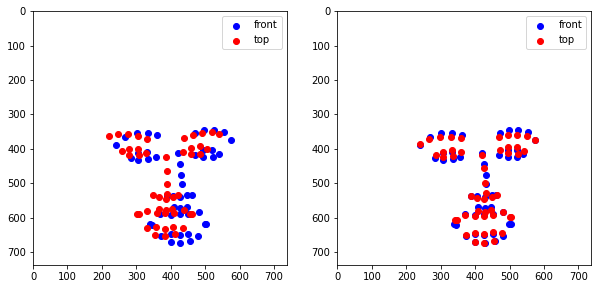

Original distance:  39.68015
New distance:  8.493903976270829


In [22]:
warped_top_pts_array_2 = np.matmul(ls_m, new_top_pts_array)
normalized_warped_top_pts_array_2 = warped_top_pts_array_2 / warped_top_pts_array_2[2,:]
vis_warped_top_pts_array_2 = normalized_warped_top_pts_array_2.transpose()[:, :2]
 
warped_top_ldms_2 = np.matmul(ls_m, new_top_ldms)
normalized_warped_top_ldms_2 = warped_top_ldms_2 / warped_top_ldms_2[2,:]
new_normalized_top_ldms_2 = normalized_warped_top_ldms_2.transpose()[:, :2]

original_x = new_normalized_top_ldms_2[:, 0]
original_y = new_normalized_top_ldms_2[:, 1]
r = new_top_ldms_r[-1, :]

if distortion_mode == 'radial':
    x = original_x * (1 + k1 * r**2 + k2 * r**4)
    y = original_y * (1 + k1 * r**2 + k2 * r**4)
elif distortion_mode == 'tangential':
    print(p1)
    print(p2)
    x = 2 * p1 * original_x * original_y + p2 * (r**2 + 2 * original_x**2)
    y = p1 * (r**2 + 2 * original_y**2) + 2 * p2 * original_x * original_y
elif distortion_mode == 'combined':
    x = original_x * (1 + k1 * r**2 + k2 * r**4) + 2 * p1 * original_x * original_y + p2 * (r**2 + 2 * original_x**2)
    y = original_y * (1 + k1 * r**2 + k2 * r**4) + p1 * (r**2 + 2 * original_y**2) + 2 * p2 * original_x * original_y
elif distortion_mode == 'none':
    x = original_x
    y = original_y

vis_top_pred_ldms_2 = np.hstack((x[:, np.newaxis], y[:, np.newaxis]))

vis_two_pts(vis_top_ldms, vis_top_pred_ldms_2, vis_front_ldms)